In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

In [2]:
def classify_examples(X: np.ndarray, Y: np.ndarray, k: int = 3) -> np.ndarray:
    """
    Classify examples as noisy or safe based on their k nearest neigbors.

    Args:
        X (numpy.ndarray): The feature matrix of shape (n_samples, n_features).
        Y (numpy.ndarray): The target labels of shape(n_samples,).
        k (int, optional): The number of nearest neighbors to consider, defaults to 3.
    
    Returns:
        numpy.ndarray: An array of flags indicating the type of each example (0 for safe, 1 for noisy).
    """
    n_samples = X.shape[0]
    flags = np.zeros(n_samples, dtype=int)  # Intialize flags for all examples as safe

    # Fit a k-nearest neighbors model
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X)

    for i in range(n_samples):
        example = X[i]
        label = Y[i]

        # Find the indices of the k nearest neigbors
        indices = nn.kneighbors([example], return_distance=False)

        # Exclude the current example itself from the neigbors
        neighbors_indices = indices[0][1:]

        # Check if the majority of neighbors have the same label as the current example
        if np.sum(Y[neighbors_indices] == label) >= k // 2:
            flags[i] = 0    # Set flag as safe
        else:
            flags[i] = 1    # Set flag as noisy
    return flags

In [3]:
def find_knn_indices(k, majority_class, example, safe_noisy_class, flags, Y, X):
    """
    Find the indices of the safe examples among its k nearest neigbors.

    Args:
        k (int): The number of nearest neigbors to consider.
        majority_class (int): The label of the majority class.
        example (np.ndarray): The example for which to find the nearest neigbors.
        safe_noisy_class (int): The class type (0 for safe, 1 for noisy) to consider.
        flags (np.ndarray): The flags indicating the type of each example (0 for safe, 1 for noisy).
        Y (np.ndarray): The target labels of shape (n_samples,)
        X (np.ndarray): The feature matrix of shape (n_samples, n_features).

    Returns:
        np.ndarray: The indices of the safe examples among its k nearest neigbors.
    """
    # Find the indices of the safe examples among its k nearest neigbors
    safe_indices = np.where((flags == safe_noisy_class) & (Y == majority_class))[0]

    # Calculate distances between the example and safe examples
    distances = []
    for safe_ind in safe_indices:
        distances.append(np.linalg.norm(X[safe_ind] - example))

    # Combine distances and indices
    combined = zip(distances, safe_indices)

    # Sort the combined list based on distances
    sorted_combined = sorted(combined)
    sorted_distances, sorted_indices = zip(*sorted_combined)

    # Get the indices of the k nearest neigbors
    knn_indices = sorted_indices[:k]
    return knn_indices[:k]
    

In [4]:
def weak_amplification(X: np.ndarray, Y: np.ndarray, flags: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Performs weak amplification by creating copies of noisy examples.

    Args:
        X (numpy.ndarray): The feature matrix of shape (n_samples, n_features).
        Y (numpy.ndarray): The target labels of shape (n_samples,).
        flags (numpy.ndarray): The flags indicating the type of each example (0 for safe, 1 for noisy).

    Returns:
        tuple[numpy.ndarray, numpy.ndarray]: The updated feature matrix after ampflication and 
                                             the updated target labels after amplification.
    """
    n_samples = X.shape[0]  # Get the number of samples in the feature matrix X
    new_X = X.copy()    # Create copy of the feature matrix X to store the updated values
    new_Y = Y.copy()    # Create copy of the target labels Y to store the updated values
    flags_new = flags.copy()
    k = 3   # Set the value of k to determine the number of nearest neigbors to consider

    # Determine the majority class label based on the target labels
    majority_class_label = np.argmax(np.bincount(Y))

    for i in range(n_samples):
        if flags[i] == 1:   # Check it the sample is flagged as noisy
            example = X[i]  # Get the example for the current sample
            label = Y[i]    # Get the label for the current sample

            # Find the indexes of safe majority class examples among the k nearest neighbors
            safe_indices = find_knn_indices(k, majority_class_label, example, 0, flags, Y, X)
            
            # Amplify the example by creating copies
            for idx in safe_indices:
                new_X = np.vstack((new_X, example))
                new_Y = np.hstack((new_Y, label))
                flags_new = np.hstack((flags_new, 1))
    return new_X, new_Y, flags_new

In [5]:
import unittest

class TestWeakAmplification(unittest.TestCase):
    def test_weak_amplification(self):
        X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
        y = np.array([0, 1, 0, 1])
        flags = np.array([0, 1, 1, 0])
        expected_X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [3, 4], [5, 6]])
        expected_y = np.array([0, 1, 0, 1, 1, 0])

        new_X, new_y, _ = weak_amplification(X, y, flags)

        np.testing.assert_array_equal(new_X, expected_X)
        np.testing.assert_array_equal(new_y, expected_y)

    def test_weak_amplification_no_noisy_examples(self):
        X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
        y = np.array([0, 1, 0, 1])
        flags = np.array([0, 0, 0, 0])
        expected_X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
        expected_y = np.array([0, 1, 0, 1])

        new_X, new_y, _ = weak_amplification(X, y, flags)

        np.testing.assert_array_equal(new_X, expected_X)
        np.testing.assert_array_equal(new_y, expected_y)

unittest.main(argv=[''], exit=False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.006s

OK


In [6]:
# Example usage
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
y = np.array([0, 0, 1, 1, 0])
flags = classify_examples(X, y)
print("flags", flags)

new_X, new_y, _ = weak_amplification(X, y, flags)
print(new_X)
print(new_y)

flags [0 0 0 0 1]
[[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]
 [ 9 10]
 [ 9 10]]
[0 0 1 1 0 0 0]


In [7]:
def weak_amplification_and_relabeling(X: np.ndarray, y: np.ndarray, flags: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Perform weak amplification and relabeling by creating copies of noisy examples and relabeling their nearest noisy neighbors.

    Args:
        X (np.ndarray): The feature matrix of shape (n_samples, n_features).
        y (np.ndarray): The target labels of shape (n_samples,).
        flags (np.ndarray): The flags indicating the type of each example (0 for safe, 1 for noisy).

    Returns:
        tuple[np.ndarray, np.ndarray]: The updated feature matrix after amplification and relabeling, and the updated target labels after amplification and relabeling.
    """
    # Get the number of samples in the feature matrix X
    n_samples = X.shape[0]

    # Create copies of the feature matrix X and the target labels y to store the updated values
    new_X = X.copy()
    new_y = y.copy()
    flags_new = flags.copy()

    # Find the majority class label by counting the occurrences of each class label in y and selecting the label with the highest count
    majority_class_label = np.argmax(np.bincount(y))

    # Get the unique class labels present in the target labels y
    unique_labels = np.unique(y)

    # Find the minority class label by identifying the label that is not the majority class label
    minority_class_label = np.setdiff1d(unique_labels, majority_class_label)[0]

    # Set the value of k for the number of nearest neighbors to consider
    k = 3

    # Iterate over each sample in the dataset
    for i in range(n_samples):
        # If the sample is flagged as noisy (flags[i] == 1)
        if flags[i] == 1:
            # Get the example and label for the current sample
            example = X[i]
            label = y[i]

            # Find the indices of the safe examples among its k nearest neighbors by calling the find_knn_indices function
            safe_indices = find_knn_indices(k, majority_class_label, example, 0, flags, y, X)

            # Amplify the example by creating copies of it and appending them to new_X and new_y
            for idx in safe_indices:
                new_X = np.vstack((new_X, example))
                new_y = np.hstack((new_y, label))
                flags_new = np.hstack((flags_new, 1)) # flags_new moze miec inna definicje niz flags

            # Relabel the noisy neighbors in the majority class to the minority class by updating their labels in new_y
            noisy_indices = find_knn_indices(k, majority_class_label, example, 1, flags, y, X)
            for idx in noisy_indices:
                new_y[idx] = minority_class_label

    # Return the updated feature matrix new_X and the updated target labels new_y
    return new_X, new_y, flags_new

In [8]:
class TestWeakAmplificationAndRelabeling(unittest.TestCase):
    def test_weak_amplification_and_relabeling(self):
        # Test data
        X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
        y = np.array([0, 0, 1, 1])
        flags = np.array([0, 1, 1, 0])
        
        # Expected output
        expected_X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [3, 4], [5, 6]])
        expected_y = np.array([0, 1, 1, 1, 0, 1])
        
        # Call the function to get the actual output
        actual_X, actual_y, _ = weak_amplification_and_relabeling(X, y, flags)
        
        # Compare the actual and expected outputs
        np.testing.assert_array_equal(actual_X, expected_X)
        np.testing.assert_array_equal(actual_y, expected_y)

unittest.main(argv=[''], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.008s

OK


In [9]:
# Example usage
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14]])
y = np.array([0, 0, 1, 1, 0, 1, 0])
flags = classify_examples(X, y)
print("flags", flags)

# Weak Amplification and Relabeling
new_X_weak_relabel, new_y_weak_relabel, _ = weak_amplification_and_relabeling(X, y, flags)
print("Weak Amplification and Relabeling:")
print("Original X:")
print(X)
print("Original y:")
print(y)
print("New X after weak amplification and relabeling:")
print(new_X_weak_relabel)
print("New y after weak amplification and relabeling:")
print(new_y_weak_relabel)
print()

flags [0 0 0 0 1 1 0]
Weak Amplification and Relabeling:
Original X:
[[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]
 [11 12]
 [13 14]]
Original y:
[0 0 1 1 0 1 0]
New X after weak amplification and relabeling:
[[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]
 [11 12]
 [13 14]
 [ 9 10]
 [ 9 10]
 [ 9 10]
 [11 12]
 [11 12]
 [11 12]]
New y after weak amplification and relabeling:
[0 0 1 1 1 1 0 0 0 0 1 1 1]



In [10]:
def strong_amplification(X: np.ndarray, y: np.ndarray, flags: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Perform strong amplification by creating copies of safe and noisy examples, and remove all noisy majority class examples.

    Args:
        X (np.ndarray): The feature matrix of shape (n_samples, n_features).
        y (np.ndarray): The target labels of shape (n_samples,).
        flags (np.ndarray): The flags indicating the type of each example (0 for safe, 1 for noisy).

    Returns:
        tuple[np.ndarray, np.ndarray]: The updated feature matrix after amplification, and the updated target labels after amplification.
    """
    # Get the number of samples in the feature matrix X
    n_samples = X.shape[0]

    # Create copies of the feature matrix X, target labels y, and flags to store the updated values
    new_X = X.copy()
    new_y = y.copy()
    flags_new = flags.copy()

    # Set the value of k for the number of nearest neighbors to consider as 3
    k = 3

    # Determine the majority class label by counting the occurrences of each class label in y and selecting the label with the highest count
    majority_class_label = np.argmax(np.bincount(y))

    # Get the unique class labels present in the target labels y
    unique_labels = np.unique(y)

    # Determine the minority class label by excluding the majority class label from the unique labels
    minority_class_label = np.setdiff1d(unique_labels, majority_class_label)[0]

    for i in range(n_samples):
        # If the sample is flagged as safe (flags[i] == 0) and has the minority class label
        if flags[i] == 0 and y[i] == minority_class_label:
            # Get the example and label for the current sample
            example = X[i]
            label = y[i]

            # Find the indices of the safe examples among its k nearest neighbors by calling the find_knn_indices function
            knn_indices = find_knn_indices(k, majority_class_label, example, 0, flags, y, X)

            # Amplify the example by creating copies and append them to new_X, new_y, and flags_new arrays
            for idx in knn_indices:
                new_X = np.vstack((new_X, example))
                new_y = np.hstack((new_y, label))
                flags_new = np.hstack((flags_new, 0))

        # If the sample is flagged as noisy (flags[i] == 1) and has the minority class label
        if flags[i] == 1 and y[i] == minority_class_label:
            # Get the example and label for the current sample
            example = X[i]
            label = y[i]

            # Classify the examples using k=5 to determine the flags for each example
            flags_5 = classify_examples(X, y, 5)

            # Check if the flag for the current sample is safe (flag_i == 0) and set k_s to 3, otherwise set k_s to 5
            flag_i = flags_5[i]
            if flag_i == 0:
                k_s = 3
            else:
                k_s = 5

            # Find the indices of the safe examples among its k_s nearest neighbors by calling the find_knn_indices function
            knn_indices = find_knn_indices(k_s, majority_class_label, example, 0, flags, y, X)

            # Amplify the example by creating copies and append them to new_X, new_y, and flags_new arrays
            for idx in knn_indices:
                new_X = np.vstack((new_X, example))
                new_y = np.hstack((new_y, label))
                flags_new = np.hstack((flags_new, 1))

    # Return the updated feature matrix new_X and the updated target labels new_y
    return new_X, new_y, flags_new

In [11]:
# Example usage
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
y = np.array([0, 0, 1, 1, 0])
flags = classify_examples(X, y)
print("flags", flags)

new_X, new_y, _ = weak_amplification(X, y, flags)
print(new_X)
print(new_y)

new_X, new_y, _ = weak_amplification_and_relabeling(X, y, flags)
print(new_X)
print(new_y)

new_X, new_y, _ = strong_amplification(X, y, flags)
print(new_X)
print(new_y)

flags [0 0 0 0 1]
[[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]
 [ 9 10]
 [ 9 10]]
[0 0 1 1 0 0 0]
[[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]
 [ 9 10]
 [ 9 10]]
[0 0 1 1 1 0 0]
[[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]
 [ 5  6]
 [ 5  6]
 [ 7  8]
 [ 7  8]]
[0 0 1 1 0 1 1 1 1]


In [12]:
def spider(X, y, amplification_type='weak_amplification'):
    majority_class_label = np.argmax(np.bincount(y))
    flags = classify_examples(X, y)
    if amplification_type == 'weak_amplification':
        new_X, new_y, new_flags = weak_amplification(X, y, flags)
    elif amplification_type == 'weak_amplification_with_relabeling':
        new_X, new_y, new_flags = weak_amplification_and_relabeling(X, y, flags)
    else:
        new_X, new_y, new_flags = strong_amplification(X, y, flags)
    # Remove all noisy majority class examples from new_X, new_y, and flags_new arrays
    new_X = new_X[~((new_flags == 1) & (new_y == majority_class_label))]
    new_y = new_y[~((new_flags == 1) & (new_y == majority_class_label))]
    return new_X, new_y

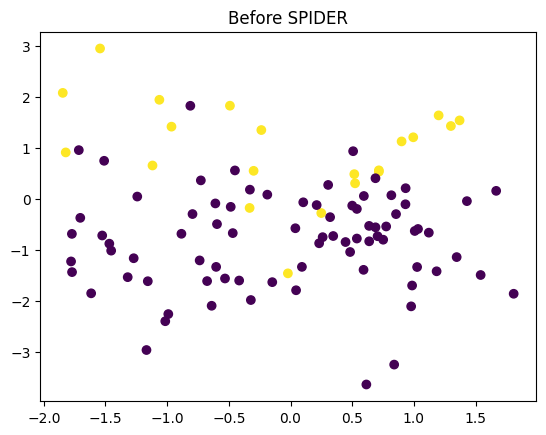

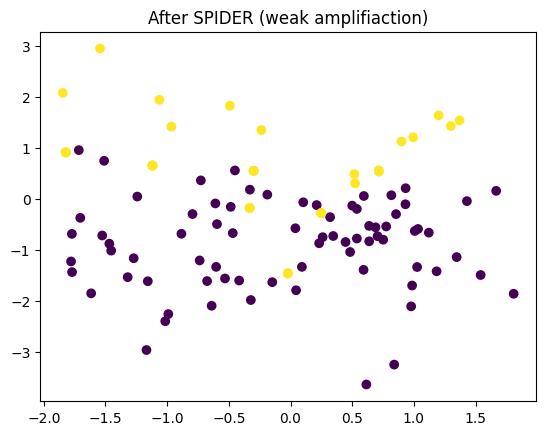

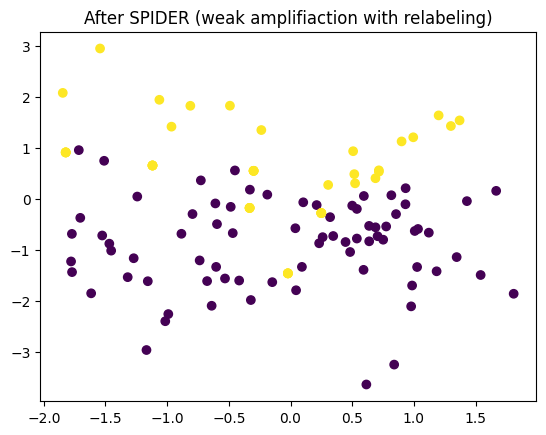

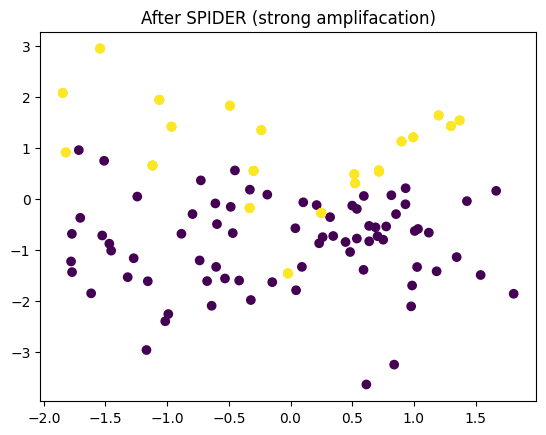

In [21]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
X, Y = make_classification(n_features=2, n_informative=2, n_repeated=0, n_redundant=0, weights=[0.8, 0.2])
plt.figure()
plt.title("Before SPIDER")
plt.scatter(X[:,0], X[:,1], c=Y)
plt.figure()
plt.title("After SPIDER (weak amplifiaction)")
new_X_spider, new_y_spider = spider(X, Y, amplification_type='weak_amplification')
plt.scatter(new_X_spider[:,0], new_X_spider[:,1], c=new_y_spider)
plt.figure()
plt.title("After SPIDER (weak amplifiaction with relabeling)")
new_X_spider, new_y_spider = spider(X, Y, amplification_type='weak_amplification_with_relabeling')
plt.scatter(new_X_spider[:,0], new_X_spider[:,1], c=new_y_spider)
plt.figure()
plt.title("After SPIDER (strong amplifacation)")
new_X_spider, new_y_spider = spider(X, Y, amplification_type='strong amplifacation')
plt.scatter(new_X_spider[:,0], new_X_spider[:,1], c=new_y_spider)



